In [1]:
import matplotlib.pyplot as plt
from IPython.display import Audio
import tensorflow_datasets as tfds
import tensorflow as tf
from utils import compute_mfcc_tf, scheduler, acc_loss_plot, split_distribution, plot_distributions
from config import config
from Models.model_9 import Model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import os

tf.random.set_seed(config.SEED)

/Users/traveler/Desktop/VSCODEs/research/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
wave_path = "/Users/traveler/Downloads/output_4Mu6Y7Yz3C-V_1.wav"
audio = tf.io.read_file(wave_path)
audio, sr = tf.audio.decode_wav(audio, desired_channels=1)
audio = tf.squeeze(audio, axis=-1)
Audio(audio.numpy(), rate=sr.numpy())

In [3]:
mfcc = compute_mfcc_tf(audio, sr)

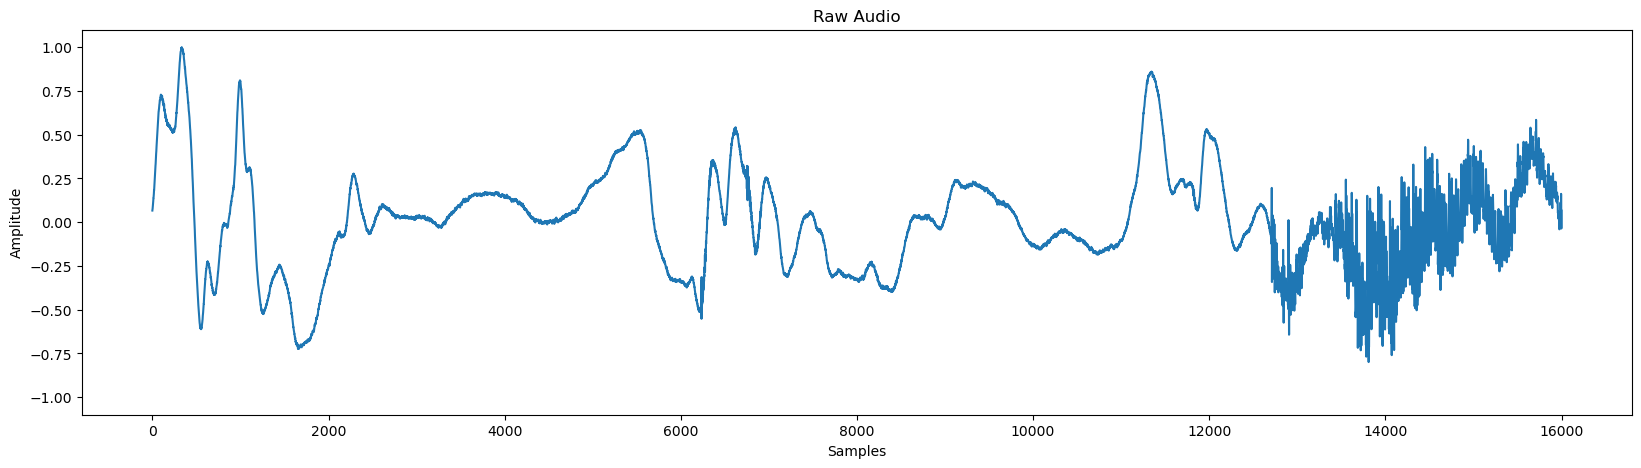

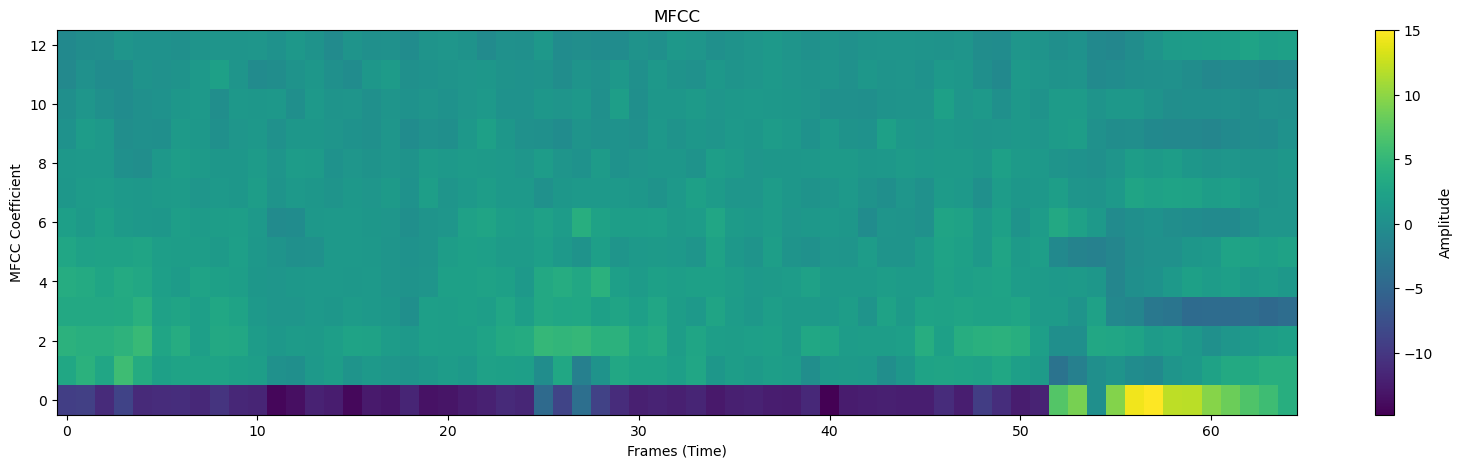

In [4]:
plt.figure(figsize=(20, 5))
plt.plot(audio)
plt.title("Raw Audio")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
_ = plt.ylim([-1.1, 1.1])

plt.figure(figsize=(20, 5))
plt.imshow(mfcc.numpy().T, aspect='auto', origin='lower')
plt.title("MFCC")
plt.xlabel("Frames (Time)")
plt.ylabel("MFCC Coefficient")
plt.colorbar(label="Amplitude")
plt.show()

In [5]:
(ds_train, ds_val, ds_test), ds_info = tfds.load("speech_commands", split=['train', 'validation', 'test'], as_supervised=True, with_info=True)
print(len(ds_train), "-",ds_train.element_spec)
print("-"*70)
print(len(ds_val), "-",ds_val.element_spec)
print("-"*70)
print(len(ds_test), "-",ds_test.element_spec)

85511 - (TensorSpec(shape=(None,), dtype=tf.int16, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
----------------------------------------------------------------------
10102 - (TensorSpec(shape=(None,), dtype=tf.int16, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
----------------------------------------------------------------------
4890 - (TensorSpec(shape=(None,), dtype=tf.int16, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


2025-11-02 00:58:58.951569: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


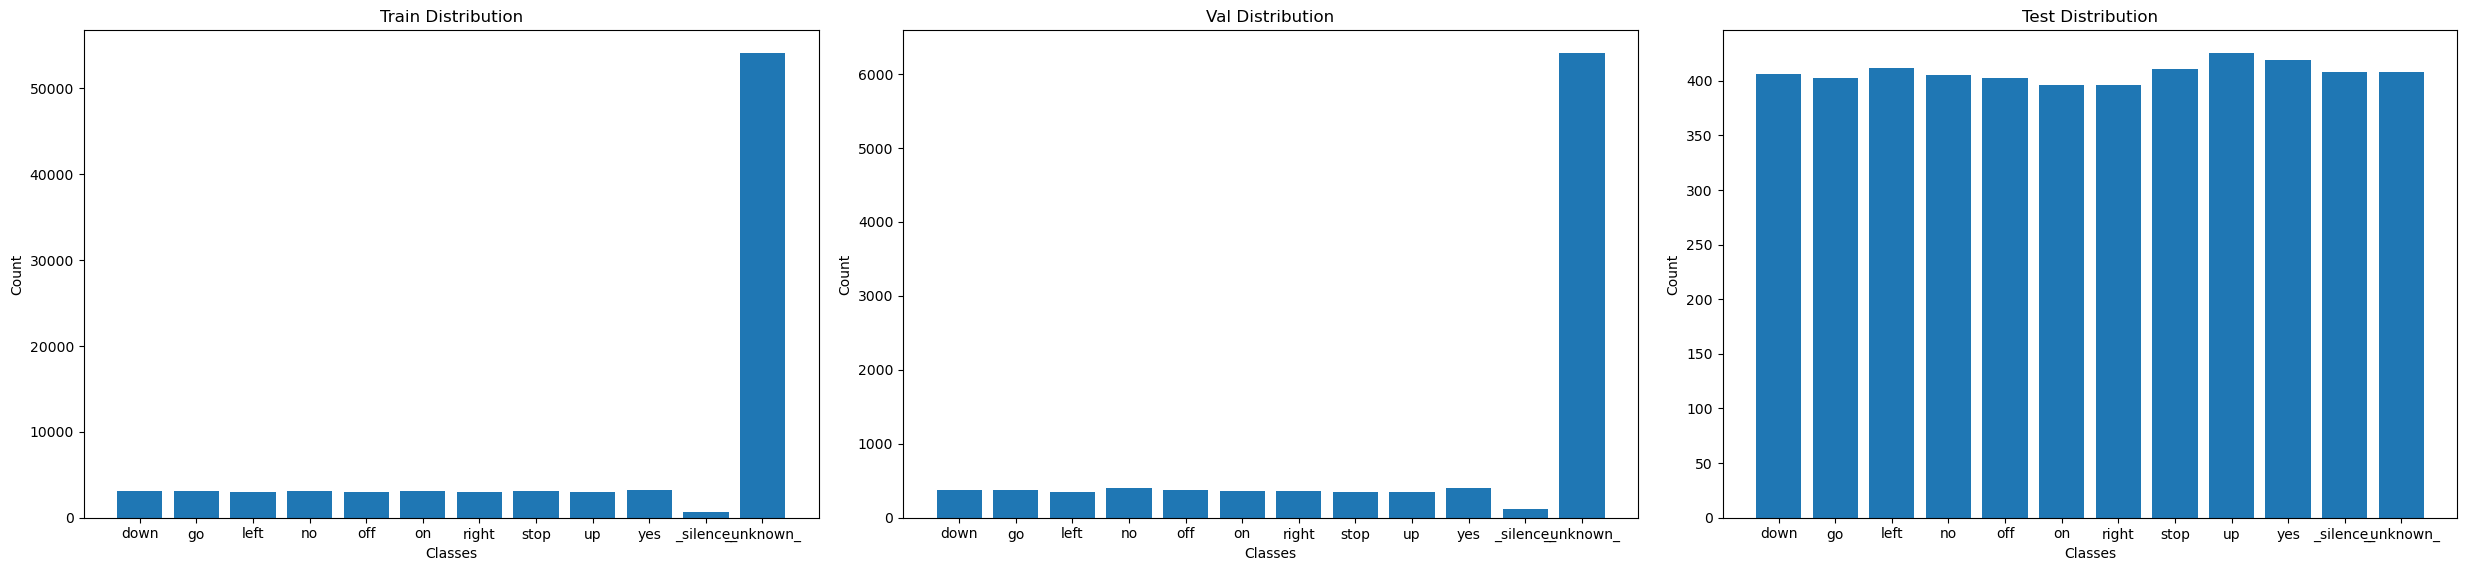

In [6]:
train_dist, _ = split_distribution(ds_train, ds_info)
val_dist, _ = split_distribution(ds_val, ds_info)
test_dist, test_labels = split_distribution(ds_test, ds_info, give_labels=True)
plot_distributions(train_dist, val_dist, test_dist)

In [7]:
def preprocess(audio, label):
	audio = tf.cast(audio, tf.float32) / 32768.0
	desired_length = 16000
	audio = tf.cond(
		tf.shape(audio)[0] < desired_length,
		lambda: tf.pad(audio, [[0, desired_length - tf.shape(audio)[0]]]),
		lambda: audio[:desired_length]
	)
	mfcc = compute_mfcc_tf(audio, config.SR)
	# mfcc = tf.expand_dims(mfcc, axis=-1)
	label = tf.one_hot(label, config.NUM_CLASSES)
	return mfcc, label

ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
ds_train = ds_train.batch(config.BATCH_SIZE)
ds_train = ds_train.prefetch(config.BATCH_SIZE)

ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.cache()
ds_val = ds_val.batch(config.BATCH_SIZE)
ds_val = ds_val.prefetch(config.BATCH_SIZE)

ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(config.BATCH_SIZE)
ds_test = ds_test.prefetch(config.BATCH_SIZE)

In [8]:
model = Model()
model.build(input_shape = [None, *config.INPUT_SHAPE])
model.summary()
os.makedirs(f"Results/{model.name}", exist_ok=True)

config.model_name = model.name

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv1d (Separable  multiple                 263       
 Conv1D)                                                         
                                                                 
 separable_conv1d_1 (Separab  multiple                 592       
 leConv1D)                                                       
                                                                 
 separable_conv1d_2 (Separab  multiple                 2208      
 leConv1D)                                                       
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 global_average_pooling1d (G  multiple                 0         
 lobalAveragePooling1D)                                    

In [9]:
model.compile(
	optimizer = tf.keras.optimizers.legacy.Adam(0.001),
	loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
	metrics = [
		tf.keras.metrics.CategoricalAccuracy(),
		# tf.keras.metrics.F1Score(),
	],
)

In [10]:
history = model.fit(
	ds_train,
	validation_data = ds_val,
	epochs = 100,
	verbose = 2,
	callbacks = [
		tf.keras.callbacks.LearningRateScheduler(
			scheduler,
			verbose=0,
		),
		tf.keras.callbacks.ModelCheckpoint(
			config.BEST_WEIGHTS_PATH,
			monitor='val_loss',
			verbose=0,
			save_best_only=True,
			save_weights_only=True,
			mode='min',
		)
	]
)

Epoch 1/100
1337/1337 - 52s - loss: 1.2787 - categorical_accuracy: 0.6412 - val_loss: 0.9654 - val_categorical_accuracy: 0.6919 - lr: 0.0010 - 52s/epoch - 39ms/step
Epoch 2/100
1337/1337 - 7s - loss: 0.7893 - categorical_accuracy: 0.7460 - val_loss: 0.6182 - val_categorical_accuracy: 0.8159 - lr: 0.0010 - 7s/epoch - 5ms/step
Epoch 3/100
1337/1337 - 8s - loss: 0.6193 - categorical_accuracy: 0.8030 - val_loss: 0.5351 - val_categorical_accuracy: 0.8342 - lr: 0.0010 - 8s/epoch - 6ms/step
Epoch 4/100
1337/1337 - 7s - loss: 0.5613 - categorical_accuracy: 0.8242 - val_loss: 0.4933 - val_categorical_accuracy: 0.8463 - lr: 0.0010 - 7s/epoch - 5ms/step
Epoch 5/100
1337/1337 - 7s - loss: 0.5232 - categorical_accuracy: 0.8361 - val_loss: 0.4648 - val_categorical_accuracy: 0.8550 - lr: 0.0010 - 7s/epoch - 5ms/step
Epoch 6/100
1337/1337 - 7s - loss: 0.4955 - categorical_accuracy: 0.8460 - val_loss: 0.4639 - val_categorical_accuracy: 0.8577 - lr: 0.0010 - 7s/epoch - 5ms/step
Epoch 7/100
1337/1337 - 7

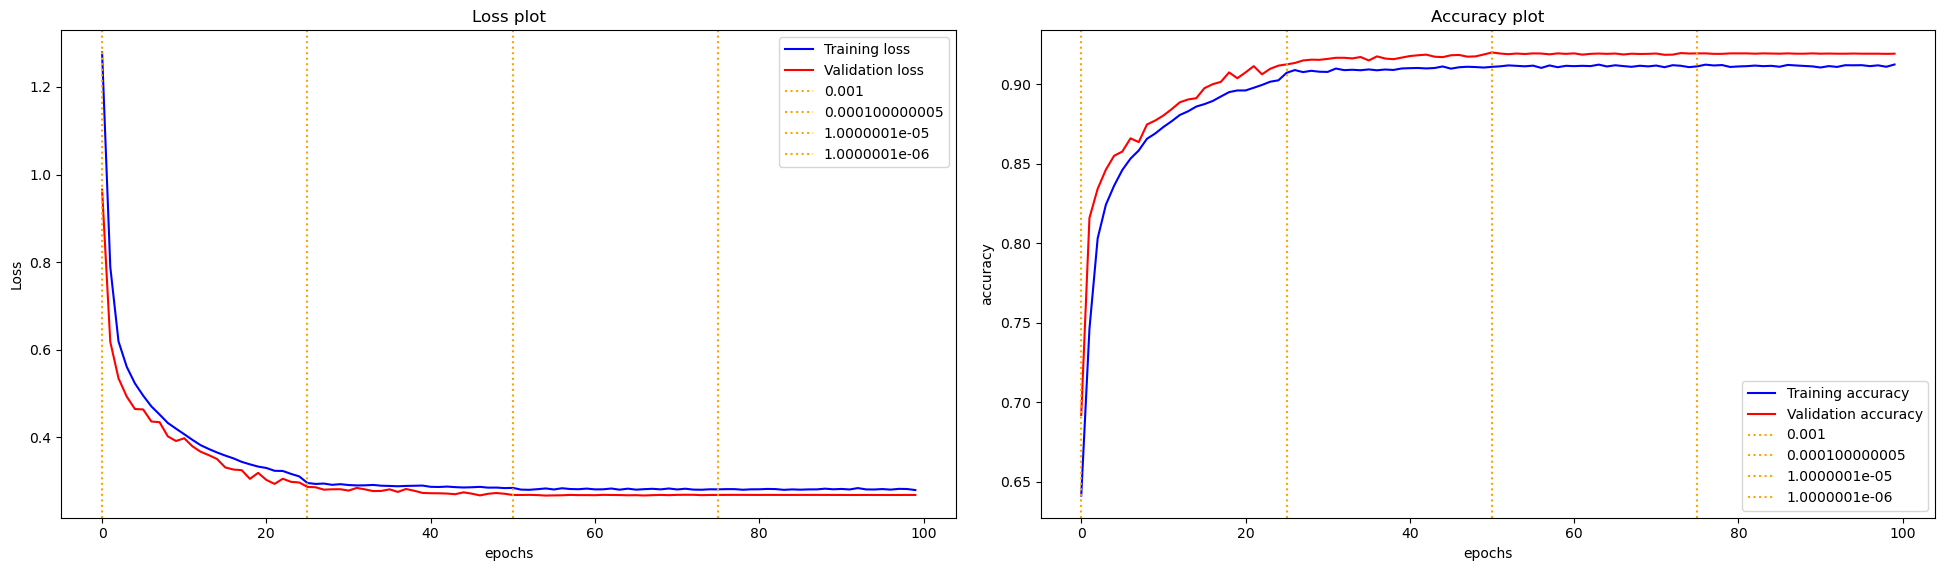

In [11]:
acc_loss_plot(history.history, size = [20, 6], path = config.TRAIN_PLOT_PATH)

In [12]:
model.evaluate(ds_test)
model.load_weights(config.BEST_WEIGHTS_PATH)
model.evaluate(ds_test)

77/77 [==============================] - 0s 1ms/step - loss: 0.5316 - categorical_accuracy: 0.8346


[0.531636655330658, 0.8345603346824646]

In [13]:
model.load_weights(config.BEST_WEIGHTS_PATH)
model.evaluate(ds_test)

77/77 [==============================] - 0s 1ms/step - loss: 0.5316 - categorical_accuracy: 0.8346


[0.531636655330658, 0.8345603346824646]

In [14]:
preds = model.predict(ds_test)
pred_labels = []
for pred in preds:
	pred_labels.append(int(tf.argmax(pred)))

77/77 [==============================] - 0s 1ms/step


In [15]:
report = classification_report(test_labels, pred_labels, target_names = ds_info.features["label"].names)
print(report)

with open(config.CLS_REPORT_PATH, "w") as f:
    f.write(report)

              precision    recall  f1-score   support

        down       0.94      0.77      0.85       406
          go       0.96      0.75      0.84       402
        left       0.97      0.83      0.89       412
          no       0.88      0.85      0.87       405
         off       0.93      0.85      0.89       402
          on       0.97      0.81      0.88       396
       right       0.99      0.79      0.88       396
        stop       0.97      0.84      0.90       411
          up       0.92      0.80      0.86       425
         yes       0.93      0.89      0.91       419
   _silence_       1.00      0.85      0.92       408
   _unknown_       0.39      0.97      0.56       408

    accuracy                           0.83      4890
   macro avg       0.90      0.83      0.85      4890
weighted avg       0.90      0.83      0.85      4890



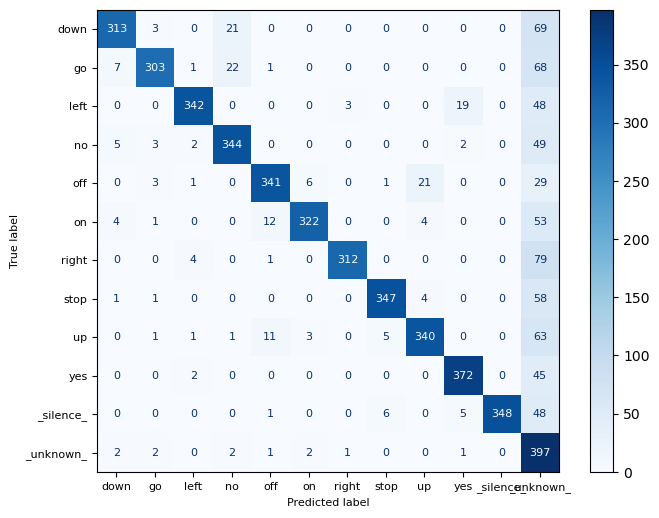

In [16]:
cm = confusion_matrix(test_labels, pred_labels)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ds_info.features["label"].names)
fig, ax = plt.subplots(figsize=(8, 6))
cm_plot.plot(ax=ax, cmap="Blues")
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
for text in ax.texts:
    text.set_fontsize(8)
ax.set_xlabel("Predicted label", fontsize=8)
ax.set_ylabel("True label", fontsize=8)
plt.savefig(config.CM_PATH, dpi = 300)